In [2]:
import fastf1
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
import warnings
from pathlib import Path
import seaborn as sns
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
import datetime

warnings.filterwarnings('ignore')
logging.getLogger('fastf1').setLevel(logging.WARNING)

fastf1.Cache.enable_cache(os.getcwd())

# Window size (range of the sliding window used in delta angle calculation)
N = 15

# Max and Min delta angle for a data point to be classified as being part of a corner
CORNER_THRESHOLD = 0.4
SPEED_THRESHOLD = 200

## Load and Prepare Formula 1 Race Sessions

In [ ]:
year = 2025

schedule = fastf1.get_event_schedule(year)
gp_events = schedule[schedule['EventName'].str.contains("Grand Prix")]['EventName'].tolist()
gp_events = schedule[
    (schedule['EventName'].str.contains("Grand Prix")) &
    (schedule['EventDate'] <= datetime.datetime.now())
]['EventName'].tolist()

sessions = {}

#Loading race session
def load_session(event):
    try:
        session = fastf1.get_session(year, event, 'R')
        session.load(telemetry=True, laps=True, weather=True)
        return event, session
    except Exception as e:
        print(f"Cannot load {event}.")
        return None

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(load_session, e): e for e in gp_events}
    for future in as_completed(futures):
        result = future.result()
        if result is not None:
            event, session = result
            sessions[event] = session

logger      WARNING 	Failed to load schedule from FastF1 backend!
core        WARNING 	Fixed incorrect tyre stint information for driver '87'
core        WARNING 	Fixed incorrect tyre stint information for driver '30'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core        WARNING 	Fixed incorrect tyre stint information for driver '31'
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.
core        WARNING 	Driver 81 completed the race distance 00:00.036000 before the recorded end of the session.
core        WARNING 	Fixed incorrect tyre stint information for driver '81'
core        WARNING 	Fixed incorrect tyre stint information for driver '4'
core        WARNING 	Fixed inco

## Compute Cornering and Telemetry Metrics for Each Race

In [3]:
race_stats = pd.DataFrame()
race_data = []

for event in gp_events:
    session = sessions[event]
    try:
        telemetry = session.laps.pick_driver('VER').get_telemetry()
    except Exception as e:
        print(f"Timing data not available for {event}")
        continue
    telemetry = telemetry[['X', 'Y','Speed']]

    dx1 = telemetry['X'] - telemetry['X'].shift(N)
    dy1 = telemetry['Y'] - telemetry['Y'].shift(N)
    dx2 = telemetry['X'].shift(-N) - telemetry['X']
    dy2 = telemetry['Y'].shift(-N) - telemetry['Y']

    telemetry['Event'] = event

    telemetry['Delta_Angle'] = np.arctan2(dx1*dy2 - dy1*dx2, dx1*dx2 + dy1*dy2)
    telemetry['Delta_Angle'] = telemetry['Delta_Angle'].fillna(0)

    telemetry['IsCorner'] = ((telemetry['Delta_Angle'] > CORNER_THRESHOLD) | (telemetry['Delta_Angle'] < -CORNER_THRESHOLD) | (telemetry['Speed'] < SPEED_THRESHOLD))

    race_data.append(telemetry)

race_stats = pd.concat(race_data, ignore_index=True)
race_stats.to_csv("race_stats.csv", index=False)

### Visualize Telemetry Data and Cornering Events

In [4]:
race_stats_csv = pd.read_csv("race_stats.csv")

for event in race_stats_csv["Event"].unique():
    event_data = race_stats_csv[race_stats_csv["Event"] == event]

    plt.figure(figsize=(6.4, 4.8))
    cmap = sns.color_palette('viridis', as_cmap = True)
    norm = plt.Normalize(vmin=race_stats_csv['Delta_Angle'].min(), vmax=race_stats_csv['Delta_Angle'].max())

    sc = sns.scatterplot(data=event_data,
                        x='X', y='Y',
                        hue='Delta_Angle',
                        palette='viridis',
                        hue_norm=norm,
                        legend=False,
                        edgecolor=None)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax = plt.gca())

    plt.savefig(f"{event}_deltaAngle.png")
    plt.close()

    plt.figure(figsize=(6.4, 4.8))
    sns.scatterplot(data=event_data,
                    x='X', y='Y',
                    hue='IsCorner',
                    palette={False: "blue", True: "red"},
                    edgecolor=None)

    plt.savefig(f"{event}_isCorner.png")
    plt.close()

## Extract Driver Lap Statistics and Telemetry Metrics

In [ ]:
df = pd.DataFrame()
rows = []

def pick_median(laps):
    valid_laps = laps.dropna(subset=['LapTime']).reset_index(drop=True)
    if valid_laps.empty: return None
    times = valid_laps['LapTime'].dt.total_seconds()
    median_time = np.median(times)
    median_lap_index = (times - median_time).abs().argsort().iloc[0]
    return valid_laps.iloc[median_lap_index]

for event in gp_events:
    session = sessions[event]
    weather = session.weather_data
    
    for num in session.drivers:
        driver = session.get_driver(num)['Abbreviation']
        team = session.get_driver(num)['TeamName']
        
        
        driver_laps_all = session.laps.pick_driver(driver)
        if driver_laps_all.empty:
            continue
        
        #TODO filter out wet weather laps
        driver_laps_race = driver_laps_all[( driver_laps_all['TrackStatus'] == '1') 
                                           & (driver_laps_all['PitInTime'].isna()) 
                                           & (driver_laps_all['PitOutTime'].isna()) 
                                           & (driver_laps_all['LapNumber'] > 1)].dropna(subset='LapTime').reset_index(drop=True)
        #INCLUDES laps done under green flag conditions, EXCLUDES pit in, pit out laps, as well as first lap
        
        lap_median = pick_median(driver_laps_race)
        lap_fastest = driver_laps_race.pick_fastest()
        if lap_median is None or lap_fastest is None: continue
        tel_median = lap_median.get_car_data()

        corner_speeds = tel_median.query('Speed < 200')['Speed']
        straight_speeds = tel_median.query('Speed >= 200')['Speed']

        #Getting top speed with and without DRS
        top_speed = 0
        top_speed_no_drs = 0
        for _, lap in driver_laps_race.iterlaps():
            tel = lap.get_car_data()
            if 'Speed' in tel:
                lap_top_speed = tel['Speed'].max()
                if lap_top_speed > top_speed:
                    top_speed = lap_top_speed
            else:
                continue
            
            drs = tel['DRS'].values
            if 'Speed' in tel and drs.all() != 2: # looks for laps with no DRS enabled
                lap_top_speed = tel['Speed'].max()
                if lap_top_speed > top_speed_no_drs:
                    top_speed_no_drs = lap_top_speed
            else:
                continue

        drs_delta = top_speed - top_speed_no_drs
        #TODO add top speed without drs and drs delta to df if needed

        rows.append(
            {
                "Driver": driver,
                "Team": team,
                "Event": event,
                "TyreCompound": lap_fastest['Compound'] if 'Compound' in lap_fastest else None,
                "Qualifying Time": lap_fastest['LapTime'].total_seconds() if lap_fastest['LapTime'] else None, 
                "Top Speed": top_speed,
                "AvgCornerSpeed": corner_speeds.mean() if not corner_speeds.empty else None,
                "AvgCornerEntrySpeed": corner_speeds.head(5).mean() if len(corner_speeds) >= 5 else None,
                "AvgCornerExitSpeed": corner_speeds.tail(5).mean() if len(corner_speeds) >= 5 else None,
                "AvgStraightSpeed": straight_speeds.mean()if not straight_speeds.empty else None,
                "AvgStraightEntrySpeed": straight_speeds.head(5).mean() if len(straight_speeds) >= 5 else None,
                "AvgStraightExitSpeed": straight_speeds.tail(5).mean() if len(straight_speeds) >= 5 else None,
                "ThrottleMean": tel_median['Throttle'].mean(),
                "ThrottleStdDev": tel_median['Throttle'].std(),
                "BrakeMean": tel_median['Brake'].mean(),
                "BrakeStdDev": tel_median['Brake'].std(),
                "DRSMean": tel_median['DRS'].mean()
            }
        )

        
        # df.at[i, 'AirTemp'] = weather['AirTemp']
        # df.at[i, 'TrackTemp'] = weather['TrackTemp']
        # df.at[i, 'Humidity'] = weather['Humidity']
        # df.at[i, 'Pressure'] = weather['Pressure']
        # df.at[i, 'Rainfall'] = weather['Rainfall']

df = pd.DataFrame(rows)

In [32]:
df.to_csv('f1.csv', index = False)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv("f1.csv")
df.dropna(inplace=True)

## Assess Multicollinearity in Telemetry Features

In [12]:
continuous_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
continuous_columns.remove("Qualifying Time")

# Check VIF (Multicolinearity)
formula = f'Q("Qualifying Time") ~ ' + ' + '.join([f'Q("{c}")' for c in continuous_columns])
Y, X = dmatrices(formula, data=df, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                      variable          VIF
0                    Intercept  6290.555535
1               Q("Top Speed")     6.259482
2          Q("AvgCornerSpeed")     2.740664
3     Q("AvgCornerEntrySpeed")     1.142872
4      Q("AvgCornerExitSpeed")     1.120831
5        Q("AvgStraightSpeed")     7.061505
6   Q("AvgStraightEntrySpeed")    15.019837
7    Q("AvgStraightExitSpeed")    12.498465
8            Q("ThrottleMean")     7.137255
9          Q("ThrottleStdDev")     2.113944
10              Q("BrakeMean")    66.629779
11            Q("BrakeStdDev")    65.775044
12                Q("DRSMean")     1.810409


In [13]:
# Check VIF again (Multicolinearity)
continuous_columns.remove("BrakeStdDev")
continuous_columns.remove("AvgStraightExitSpeed")
continuous_columns.remove("AvgStraightSpeed")

formula = f'Q("Qualifying Time") ~ ' + ' + '.join([f'Q("{c}")' for c in continuous_columns])
Y, X = dmatrices(formula, data=df, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                     variable          VIF
0                   Intercept  2529.499956
1              Q("Top Speed")     3.241166
2         Q("AvgCornerSpeed")     1.990485
3    Q("AvgCornerEntrySpeed")     1.067263
4     Q("AvgCornerExitSpeed")     1.074703
5  Q("AvgStraightEntrySpeed")     1.646552
6           Q("ThrottleMean")     5.468378
7         Q("ThrottleStdDev")     1.625838
8              Q("BrakeMean")     3.039454
9                Q("DRSMean")     1.688091


## Build and Evaluate Machine Learning Models

In [41]:
x = df.drop(columns=['Qualifying Time'])
x = pd.get_dummies(x, columns=['Driver', 'Team', 'Event', 'TyreCompound'], drop_first=True)
y = df['Qualifying Time']

modelval_df = pd.DataFrame(columns=['Model', 'R-Squared', 'RMSE'])

In [62]:
print(f"The shape of the df is {df.shape}")
print()
print(f"The driver distribution by {df.groupby('Team').size()} ")
print()
print(f"The size of the df is {df.size}")
print()
print("Quick statistical data of the df") 
print(df.describe())
print()
print("Data column description") 
print(df.info())

The shape of the df is (340, 17)

The driver distribution by Team
Alpine             31
Aston Martin       34
Ferrari            36
Haas F1 Team       36
Kick Sauber        33
McLaren            35
Mercedes           33
Racing Bulls       34
Red Bull Racing    34
Williams           34
dtype: int64 

The size of the df is 5780

Quick statistical data of the df
       Qualifying Time   Top Speed  AvgCornerSpeed  AvgCornerEntrySpeed  \
count       340.000000  340.000000      340.000000           340.000000   
mean         86.928224  313.111765      138.449791           155.462941   
std          10.908858   15.574330        9.118831            14.009366   
min          67.924000  263.000000      103.892086           113.200000   
25%          77.965000  304.000000      132.533239           146.750000   
50%          87.183500  312.000000      141.905609           154.500000   
75%          95.576500  324.000000      145.623336           163.750000   
max         136.121000  353.000000    

### Linear Regression

In [42]:
x_reduced = x.drop(columns=["BrakeStdDev"])
x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=1)

model_lm = LinearRegression()
model_lm.fit(x_train, y_train)

y_pred_lm = model_lm.predict(x_test)

r2_lm = r2_score(y_test, y_pred_lm)
rmse_lm = root_mean_squared_error(y_test, y_pred_lm)


modelval_df = pd.concat([modelval_df, pd.DataFrame([{'Model': 'Linear Regression',
                                                     'R-Squared': r2_lm,
                                                     'RMSE': rmse_lm}])
                                                     ], ignore_index=True)

print(f"R-Squared: {r2_lm}")
print(f"RMSE: {rmse_lm}")

R-Squared: 0.984387436064165
RMSE: 1.3543820054420703


### Random Forest Regressor

In [43]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

rf = RandomForestRegressor(random_state=1)

param_grid = {'n_estimators': list(range(1, 51)),
              'min_samples_leaf': list(range(1, 5))
              }

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=0
)

grid_search_rf.fit(x_train, y_train)

print("Best params:", grid_search_rf.best_params_)
# print("Train RMSE:", -grid_search.best_score_)

best_rf = grid_search_rf.best_estimator_

y_pred = best_rf.predict(x_test)

r2_rf = r2_score(y_test, y_pred)
rmse_rf = root_mean_squared_error(y_test, y_pred)

modelval_df = pd.concat([modelval_df, pd.DataFrame([{'Model': 'Random Forest Regression',
                                                     'R-Squared': r2_rf,
                                                     'RMSE': rmse_rf}])
                                                     ], ignore_index=True)

print(f"Test R-Squared: {r2_rf}")
print(f"Test RMSE: {rmse_rf}")

# importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False).head(10)
# importances.sort_values().plot(kind='barh')
# plt.show()

Best params: {'min_samples_leaf': 2, 'n_estimators': 46}
Test R-Squared: 0.9602586712304285
Test RMSE: 2.160853142325063


### XGBoost Regressor

In [44]:
import xgboost as xgb

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

xg = xgb.XGBRegressor(random_state=1)

param_grid = {"n_estimators": [350, 375, 400],
              "learning_rate": [0.01, 0.05, 0.1]
              }

grid_search_xgb = GridSearchCV(
    estimator=xg,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=0
)

grid_search_xgb.fit(x_train, y_train)

print("Best params:", grid_search_xgb.best_params_)

best_xgb = grid_search_xgb.best_estimator_

y_pred = grid_search_xgb.predict(x_test)

r2_xg = r2_score(y_test, y_pred)
rmse_xg = root_mean_squared_error(y_test, y_pred)

modelval_df = pd.concat([modelval_df, pd.DataFrame([{'Model': 'XGBoost Regression',
                                                     'R-Squared': r2_xg,
                                                     'RMSE': rmse_xg}])
                                                     ], ignore_index=True)

print(f"R-Squared: {r2_xg}")
print(f"RMSE: {rmse_xg}")

# importances = pd.Series(best_xgb.feature_importances_, index=x_train.columns).sort_values(ascending=False).head(10)
# importances.sort_values().plot(kind='barh')
# plt.show()

Best params: {'learning_rate': 0.05, 'n_estimators': 400}
R-Squared: 0.9871527425178656
RMSE: 1.2285965012208895


                      Model  R-Squared      RMSE
0         Linear Regression   0.984387  1.354382
1  Random Forest Regression   0.960259  2.160853
2        XGBoost Regression   0.987153  1.228597


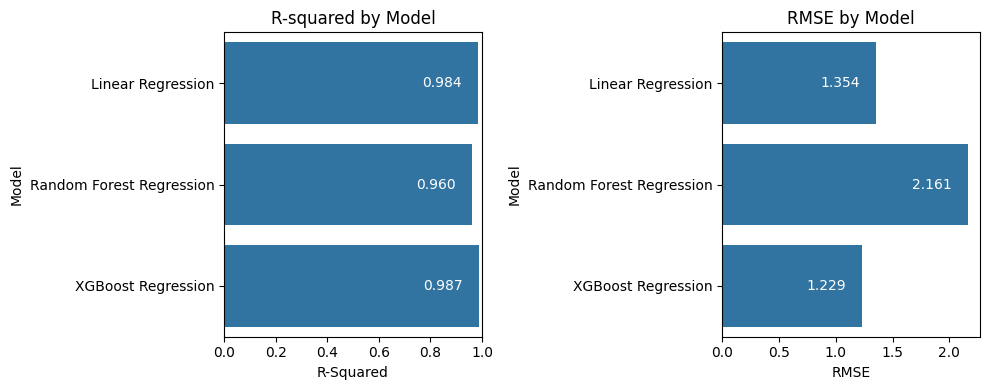

In [61]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

print(modelval_df)

sns.barplot(y='Model', x='R-Squared', data=modelval_df, ax=ax[0])
ax[0].set_title('R-squared by Model')
ax[0].set_xlim(0, 1)
for p in ax[0].patches:
    ax[0].annotate(
        format(p.get_width(), '.3f'),     
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha='left', va='center',
        fontsize=10, color='white',
        xytext=(-40, 0),       
        textcoords='offset points'
    )

sns.barplot(y='Model', x='RMSE', data=modelval_df, ax=ax[1])
ax[1].set_title('RMSE by Model')
for p in ax[1].patches:
    ax[1].annotate(
        format(p.get_width(), '.3f'),
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha='left', va='center',
        fontsize=10, color='white',
        xytext=(-40, 0),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

# Classifiers

In [21]:
labels = []
median_straight = df['AvgStraightSpeed'].median()
median_corner = df['AvgCornerSpeed'].median()

std_straight = df['AvgStraightSpeed'].std()
std_corner = df['AvgCornerSpeed'].std()

threshold = 0.5

#TODO: EDIT GOOD AND BAD PARAMETERS FOR STRAIGHTS AND CORNERS
for _, row in df.iterrows():
        bool_straight = row['AvgStraightSpeed'] >= median_straight + threshold * std_straight
        bool_corner = row['AvgCornerSpeed'] >= median_corner + threshold * std_corner

        if bool_straight and not bool_corner:
            labels.append("Good in straights")
        elif not bool_straight and bool_corner:
            labels.append("Good in corners")
        elif bool_straight and bool_corner:
            labels.append("Good at both")
        else:
            labels.append("Bad at both")

### k-Nearest Neighbors

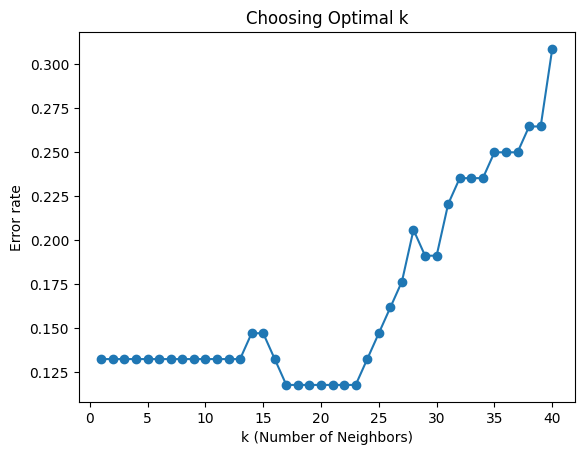

Best k: 17
Accuracy: 0.8823529411764706
                   precision    recall  f1-score   support

      Bad at both       0.85      1.00      0.92        40
     Good at both       1.00      0.67      0.80         6
  Good in corners       1.00      0.56      0.71         9
Good in straights       0.92      0.85      0.88        13

         accuracy                           0.88        68
        macro avg       0.94      0.77      0.83        68
     weighted avg       0.90      0.88      0.87        68

[[40  0  0  0]
 [ 1  4  0  1]
 [ 4  0  5  0]
 [ 2  0  0 11]]
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold

# x-axis for KNN
selector = VarianceThreshold(threshold=0.01)
x_reduced = selector.fit_transform(x)

# y-axis for kNN
le = LabelEncoder()
y = le.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size = 0.2, random_state = 1, stratify = y)

# Finding optimal k value
k_values = range(1, 41)   # Try k = 1 to 40
error_rate = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k, p=1)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    error_rate.append(np.mean(predictions != y_test))

best_k = error_rate.index(min(error_rate)) + 1

plt.plot(k_values, error_rate, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Error rate")
plt.title("Choosing Optimal k")
plt.show()
print("Best k:", best_k)

#Run proper kNN
knn = KNeighborsClassifier(n_neighbors = best_k, p=1)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(knn.get_params())


In [38]:
print("y train: ", np.unique(y_train, return_counts=True))
print("y test: ", np.unique(y_test, return_counts=True))

y train:  (array([0, 1, 2, 3]), array([158,  22,  38,  54]))
y test:  (array([0, 1, 2, 3]), array([40,  6,  9, 13]))


### Support Vector Machine

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

#x-axis for SVM
selector = VarianceThreshold(threshold=0.01)
x_reduced = selector.fit_transform(x)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_reduced)

#y-axis for SVM
y = LabelEncoder().fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.3, random_state = 1, stratify = y)

#SVM
svm = SVC(kernel='linear', C=2)
svm.fit(x_train, y_train)
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(knn.get_params())

Accuracy: 0.9411764705882353
                   precision    recall  f1-score   support

      Bad at both       0.94      0.98      0.96        59
     Good at both       1.00      0.89      0.94         9
  Good in corners       0.92      0.86      0.89        14
Good in straights       0.95      0.90      0.92        20

         accuracy                           0.94       102
        macro avg       0.95      0.91      0.93       102
     weighted avg       0.94      0.94      0.94       102

[[58  0  1  0]
 [ 0  8  0  1]
 [ 2  0 12  0]
 [ 2  0  0 18]]
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}


### Naive Bayes Classifier

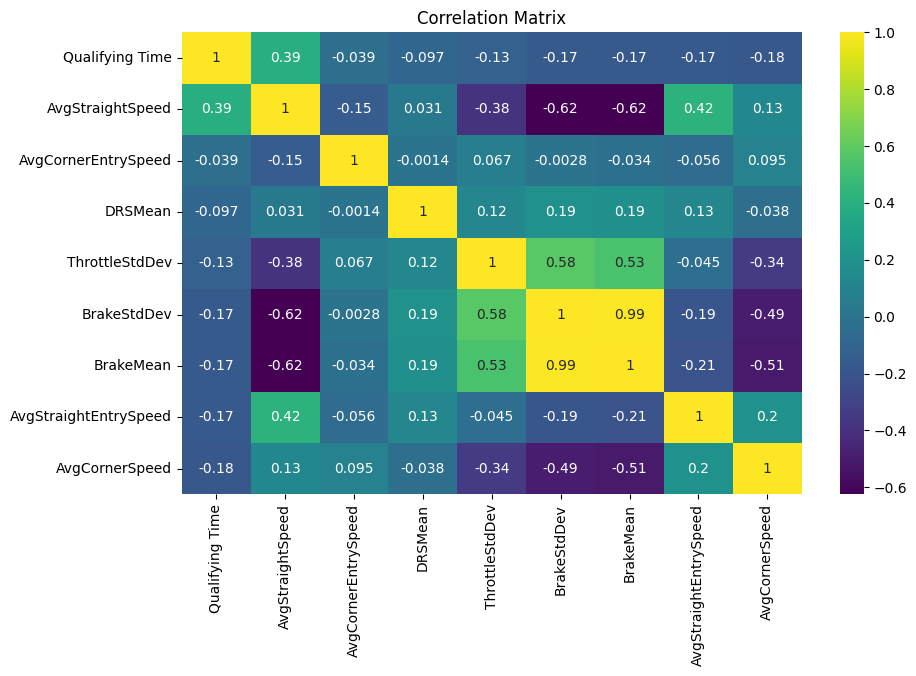

Accuracy: 0.8823529411764706
                   precision    recall  f1-score   support

      Bad at both       0.88      0.93      0.90        40
     Good at both       1.00      1.00      1.00         6
  Good in corners       0.75      0.67      0.71         9
Good in straights       0.92      0.85      0.88        13

         accuracy                           0.88        68
        macro avg       0.89      0.86      0.87        68
     weighted avg       0.88      0.88      0.88        68

[[37  0  2  1]
 [ 0  6  0  0]
 [ 3  0  6  0]
 [ 2  0  0 11]]
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

# TODO: Move corr map to data viz section + discuss suitability of NB model

# remove highly correlated columns
nb_df1 = df.drop(columns=["ThrottleMean", "Top Speed", "AvgStraightExitSpeed"])

x = nb_df1.drop(columns=['Qualifying Time', 'Driver', 'Team', 'Event', 'TyreCompound'])
y_encoded = LabelEncoder().fit_transform(labels)

# ---quality correlation matrix---
numeric_df = nb_df1.select_dtypes(include=np.number)
k = len(numeric_df.columns) - 1 # number of variables for heatmap
cols = numeric_df.corr().nlargest(k, 'Qualifying Time')['Qualifying Time'].index #change QT 
cm = numeric_df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')
plt.title('Correlation Matrix')
plt.show()
plt.close()

# dividing data
# nb_df1_features = nb_df1.drop(['Qualifying Time', 'PerformanceCategory'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1, stratify=y
)

nb = GaussianNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(knn.get_params())


### K Means

Corner speed clustering

Cluster 0: RUS, VER, ANT, PIA, LEC, HAM, ALO, HUL, OCO, SAI, BEA, TSU, COL, BOR, GAS, HAD, STR, NOR, LAW, ALB
Cluster 1: ANT, HAD, BOR, PIA, NOR, LEC, VER, RUS, ALB, HAM, LAW, GAS, BEA, TSU, STR, OCO, SAI, ALO, HUL, COL
Cluster 2: NOR, VER, PIA, HAM, TSU, LAW, BOR, ALB, LEC, RUS, SAI, HAD, ALO, HUL, GAS, STR, COL, BEA, ANT, OCO
Cluster 3: GAS, PIA, NOR, RUS, VER, ALB, ANT, LEC, HAM, SAI, TSU, HAD, OCO, HUL, ALO, STR, LAW, BEA
Cluster 4: NOR, LEC, PIA, VER, HAM, HAD, OCO, LAW, ALB, SAI, RUS, BEA, COL, BOR, STR, HUL, TSU, ANT, ALO, GAS
Cluster 5: PIA, NOR, RUS, VER, OCO, ANT, ALB, BEA, STR, SAI, HAD, LAW, DOO, BOR, HUL, TSU, ALO, LEC, HAM, GAS, COL
Cluster 6: RUS, ANT, ALB, STR, HUL, LEC, GAS, OCO, BEA, ALO, VER, NOR, PIA, HAM, HAD, TSU, SAI, DOO, LAW, BOR

Corner Speed clustering RMSE: 4.969999057018318 

Straight speed clustering

Cluster 0: NOR, VER, PIA, HAM, ALB, LEC, RUS, SAI, HAD, TSU, ALO, HUL, GAS, LAW, STR, COL, BEA, BOR, ANT, OCO
Cluster 1: PIA, NOR, L

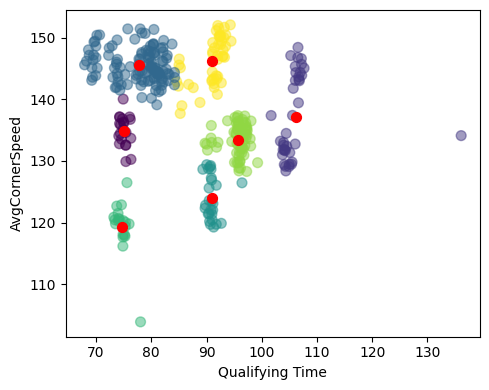

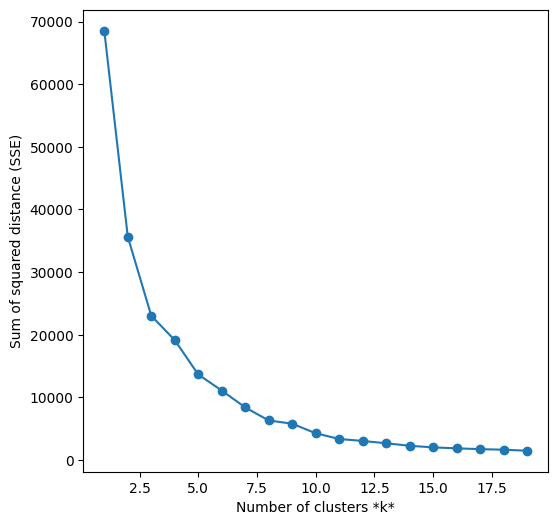

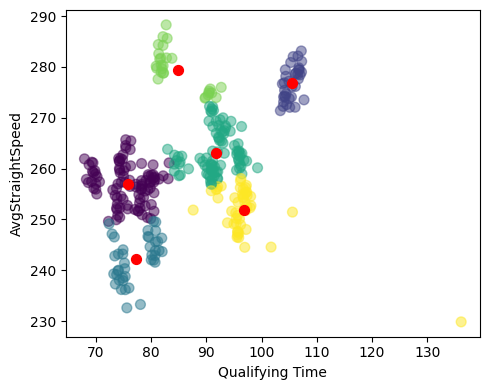

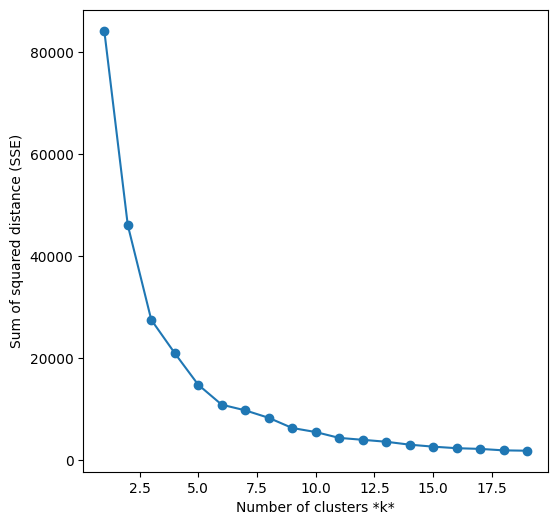

In [108]:
#k-means
from sklearn.cluster import KMeans

x = df['Qualifying Time']
hue1 = df['Driver']

# ----data exploration---
plt.figure(figsize=(10,5))
plot1 = plt.subplot(1,2,1)
sns.scatterplot(x=x, y=df['AvgCornerSpeed'], hue=hue1) #Corner speed plot
plot1.set_title('Avg Corner Speed')
# for i, driver in enumerate(df['Driver']): #label for driver for their respective dot
#     plot1.text(x.iloc[i]+0.05, df['AvgCornerSpeed'].iloc[i]+0.05, driver, fontsize=7)

plot2 = plt.subplot(1,2,2)
sns.scatterplot(x=x, y=df['AvgStraightSpeed'], hue=hue1) #Straight speed plot
plot2.set_title('Avg Straight Speed')
# for i, driver in enumerate(df['Driver']): #label for driver for their respective dot
#     plot2.text(x.iloc[i]+0.05, df['AvgStraightSpeed'].iloc[i]+0.05, driver, fontsize=7)

# making common legend
handles, labels = plt.gca().get_legend_handles_labels()
plot1.get_legend().remove()
plot2.get_legend().remove()
plt.legend(handles, labels, title='Driver', loc='center left', bbox_to_anchor=(1.02, 0.5),
           fontsize=7, title_fontsize=8, markerscale=0.6, frameon=False)

plt.tight_layout()
plt.close()

# ---apply k-means clustering (CORNER SPEED)---
features = ['Qualifying Time', 'AvgCornerSpeed']
X = df[features]

kmeans = KMeans(n_clusters=7, random_state=0) #change n clusters here
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# --accessing corner clusters---
df['Cluster_Corner'] = kmeans.labels_
print("Corner speed clustering\n")
for cluster_id in sorted(df['Cluster_Corner'].unique()):
    cluster_drivers = df.loc[df['Cluster_Corner'] == cluster_id, 'Driver'].unique()
    print(f"Cluster {cluster_id}: {', '.join(cluster_drivers)}")

# Compute RMSE manually
squared_errors = np.sum((X - centroids[labels])**2, axis=1)
cluster_rmse = np.sqrt(np.mean(squared_errors))
print("\nCorner Speed clustering RMSE:", cluster_rmse, '\n')

fig, ax = plt.subplots(1,1,figsize=(5,4))

# Plot also the training points
ax.scatter(df['Qualifying Time'], df['AvgCornerSpeed'], 
           c= kmeans.labels_.astype(float), s=50, alpha=0.5)
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
ax.set_xlabel('Qualifying Time')
ax.set_ylabel('AvgCornerSpeed')

plt.tight_layout()

sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance (SSE)');

optimal_k = list_k[np.argmin(sse)]
# print(f"Optimal k (Corner): {optimal_k}")

# k = 6, RMSE: 0.6524419587814484
# k = 7, RMSE: 0.46647730684291305
# k = 8, RMSE: 0.4158006395544338
# Value of k = 8 is optimal for corner speed

# ---apply k-means clustering (STRAIGHT SPEED)---
features = ['Qualifying Time', 'AvgStraightSpeed']
X = df[features]

kmeans = KMeans(n_clusters=6, random_state=0) #change n cluster here
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# ---accessing straight clusters---
df['Cluster_Straight'] = kmeans.labels_
print("Straight speed clustering\n")
for cluster_id in sorted(df['Cluster_Straight'].unique()):
    cluster_drivers = df.loc[df['Cluster_Straight'] == cluster_id, 'Driver'].unique()
    print(f"Cluster {cluster_id}: {', '.join(cluster_drivers)}")

# Compute RMSE manually
squared_errors = np.sum((X - centroids[labels])**2, axis=1)
straight_rmse = np.sqrt(np.mean(squared_errors))
print("\nStraight Speed RMSE:", straight_rmse)

fig, ax = plt.subplots(1,1,figsize=(5,4))

# Plot also the training points
ax.scatter(df['Qualifying Time'], df['AvgStraightSpeed'], 
           c= kmeans.labels_.astype(float), s=50, alpha=0.5)
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
ax.set_xlabel('Qualifying Time')
ax.set_ylabel('AvgStraightSpeed')

plt.tight_layout()

sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance (SSE)')

optimal_k = list_k[np.argmin(sse)]
# print(f"Optimal k (Straight): {optimal_k}")

# k = 4, RMSE: 0.7830298727862446
# k = 5, RMSE: 0.6561260588620095
# k = 6, RMSE: 0.5873858323437279
# Value of k = 6 is optimal for straight speed


### PCA

Explained variance ratio (all PCs): [0.09482212 0.05044037 0.0421999  0.03901857 0.03677633 0.03635546
 0.03604649 0.0356041 ]
Total variance (all PCs): 0.37126334274872796
Variance explained by PC1 and PC6: 0.1312


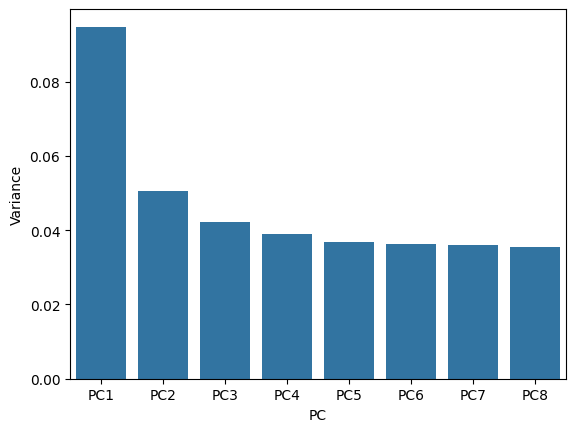

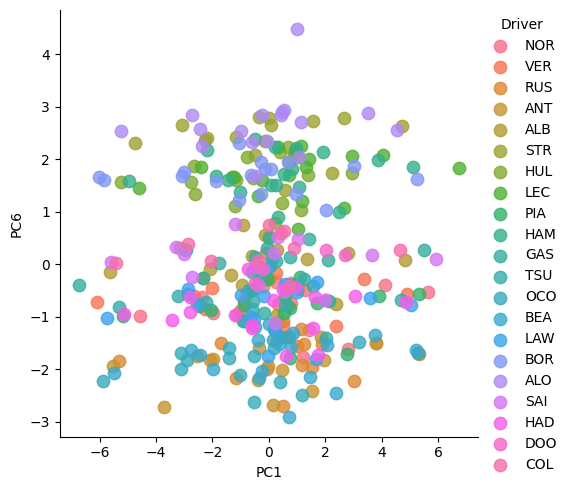

In [25]:
#PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# load dataset
# features = ['Top Speed','Qualifying Time','AvgCornerSpeed','AvgCornerEntrySpeed','AvgCornerExitSpeed',
        #     'AvgStraightSpeed','AvgStraightEntrySpeed','AvgStraightExitSpeed']

x = df.drop(columns=["Qualifying Time"]) # Separating out the features
x = pd.get_dummies(x, columns=['Driver', 'Team', 'Event', 'TyreCompound'], drop_first=True)
x_scaled = StandardScaler().fit_transform(x) # Standardizing the features

y = df['Driver'] # Separating out the target

def plot_pca(x, y, component_num=8, pc_x=1, pc_y=2):
        pca = PCA(n_components=component_num)
        pc = pca.fit_transform(x)

        #2D table
        pc_cols = [f'PC{i+1}' for i in range(component_num)]
        pc_df = pd.DataFrame(data = pc , columns = pc_cols)
        pc_df['Driver'] = y.values
        pc_df.head() #check

        print("Explained variance ratio (all PCs):",pca.explained_variance_ratio_)
        total_var = np.sum(pca.explained_variance_ratio_)
        print("Total variance (all PCs):", total_var)
        chosen_var = (pca.explained_variance_ratio_[pc_x-1] + 
                      pca.explained_variance_ratio_[pc_y-1])
        print(f"Variance explained by PC{pc_x} and PC{pc_y}: {chosen_var:.4f}")

        #Variance plot of all the PCs
        var_df = pd.DataFrame({
                'Variance':pca.explained_variance_ratio_,
                'PC':[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]})
        sns.barplot(x='PC',y="Variance", data=var_df)

        #PCA visualization
        pcx, pcy = f'PC{pc_x}', f'PC{pc_y}'
        sns.lmplot(x=pcx, y=pcy,
                data=pc_df, 
                fit_reg=False, 
                hue='Driver', # color by cluster
                legend=True,
                scatter_kws={"s": 80}) # specify the point size

plot_pca(x_scaled, y, component_num=8, pc_x=1, pc_y=6) #change pc_x and pc_y value to change PC view

In [26]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

y_test_pred = nb.predict(x_test)  #evaluate the classifier by score 
acc = metrics.accuracy_score(y_test, y_pred)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(knn.get_params())

Accuracy: 0.8823529411764706
                   precision    recall  f1-score   support

      Bad at both       0.88      0.93      0.90        40
     Good at both       1.00      1.00      1.00         6
  Good in corners       0.75      0.67      0.71         9
Good in straights       0.92      0.85      0.88        13

         accuracy                           0.88        68
        macro avg       0.89      0.86      0.87        68
     weighted avg       0.88      0.88      0.88        68

[[37  0  2  1]
 [ 0  6  0  0]
 [ 3  0  6  0]
 [ 2  0  0 11]]
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}
